# Comparison of QR algorithms

IAM 961 Numerical Linear Algebra, University of New Hampshire, J. Gibson 2024-09-23

  1. Construct matrix $A$ with known QR decomposition and given singular values.
  2. Compute QR decomposition of $A$ using Classical Graham-Schmidt, Modified Gram-Schmidt, and Householder algorithms.
  3. Compute errors in QR, Q, R, Q'Q*, and Ax=b solve.
  4. Show the deviations of the three QR factorizations from ideal, in terms of $Ax=b$ error and nonorthogonality.

In [1]:
using LinearAlgebra
using Plots
using GenericSVD
using Printf

include("qralgorithms.jl") # my code for QR algorithms

randomNormal (generic function with 2 methods)

## 1. Construct random matrix $A$ with known QR decomposition

Build $A$ as product of random unitary $Q$ and upper-triangular $R$ with a specified singular value spectrum and condition number.
The singular values are set to 
\begin{align*} 
\sigma_1, \; \sigma_2, \; \sigma_3, \ldots, \sigma_m  = 1, \; \kappa^{-1/(m-1)}, \; \kappa^{-2/(m-1)}, \ldots, \kappa^{-1}
\end{align*}
so that the ratio of the largest to smallest singular values is then $\kappa = \sigma_1/\sigma_m$. 
This quantity $\kappa$ is called the *condition number* of the matrix $A$. We will study the condition number in upcoming lectures.
Here we set the condition number $\kappa$ as a parameter in the construction of the matrix $A$.

Note that the matrix element type is parameterized. Choice for type include `Float16, Float32, Float64, BigFloat, ComplexF16, ...`.

In [2]:
# matrix A parameters
m = 5               # size of matrix A, m x m
κ = 1e2             # condition number for matrix A
T = Float64         # matrix element type
setprecision(256)   # bits of precision for BigFloat
ϵ = eps(T)          # machine precision 

# construct singular value spectrum 
c = κ^(-one(T)/(m-1) )  # auxiliary variable for singular values
σ = c.^(0:m-1)          # singular values log-scaled between 1 and 1/κ
Σ = diagm(σ)   

# construct Q,R matrices
(U,tmp) = qr(randomNormal(T,m,m)) # set U to random unitary matrix
(V,tmp) = qr(randomNormal(T,m,m)) # set V to random unitary matrix
(tmp,R) = qr(U*Σ*V')              # set R to random up-tri with given singular values
rectify!(R)                       # make Rjj positive
(Q,tmp) = qr(randomNormal(T,m,m)) # set Q to random unitary matrix 
Q = Matrix(Q)                     # convert Q from special Householder format to regular matrix

# set A to known QR decomposition
A = Q*R

5×5 Matrix{Float64}:
 -0.100817   0.459289   -0.211744     0.115627    0.103078
 -0.198248   0.225504   -0.155684     0.0606836   0.0660669
  0.412742  -0.347948    0.200077    -0.144513   -0.210022
 -0.222      0.0206993   0.00144752   0.0644525   0.170985
  0.240148  -0.341879    0.184967    -0.0555655  -0.0855339

In [3]:
σ

5-element Vector{Float64}:
 1.0
 0.31622776601683794
 0.1
 0.0316227766016838
 0.01

In [4]:
A

5×5 Matrix{Float64}:
 -0.100817   0.459289   -0.211744     0.115627    0.103078
 -0.198248   0.225504   -0.155684     0.0606836   0.0660669
  0.412742  -0.347948    0.200077    -0.144513   -0.210022
 -0.222      0.0206993   0.00144752   0.0644525   0.170985
  0.240148  -0.341879    0.184967    -0.0555655  -0.0855339

In [5]:
svdvals(A)

5-element Vector{Float64}:
 1.0
 0.316227766016838
 0.10000000000000007
 0.0316227766016838
 0.009999999999999962

### Examine and verify the constructed QR decomposition of $A$

In [6]:
Q  # stored in special format for Householder reflector matrices, won;t print values

5×5 Matrix{Float64}:
 -0.176364   0.839109    0.390662    0.299502   0.149915
 -0.346803   0.0712166  -0.702361    0.224427   0.575307
  0.722026   0.1349      0.0475013  -0.31472    0.599313
 -0.388353  -0.460361    0.591114    0.0217437  0.53606
  0.4201    -0.246363    0.0489914   0.872015   0.00337839

In [7]:
R

5×5 Matrix{Float64}:
 0.571644  -0.562097   0.312939   -0.194154   -0.295068
 0.0        0.429212  -0.208008    0.0658687   0.00522444
 0.0        0.0        0.0460474   0.0310614   0.0807707
 0.0        0.0        0.0         0.0466785   0.0409286
 0.0        0.0        0.0         0.0         0.0189619

In [8]:
Q'*Q

5×5 Matrix{Float64}:
  1.0          -1.32372e-16  -2.07971e-16   1.18271e-16  -9.03846e-17
 -1.32372e-16   1.0           2.19859e-16  -1.32974e-16  -2.10529e-17
 -2.07971e-16   2.19859e-16   1.0          -8.18078e-17   5.2048e-16
  1.18271e-16  -1.32974e-16  -8.18078e-17   1.0           1.13583e-16
 -9.03846e-17  -2.10529e-17   5.2048e-16    1.13583e-16   1.0

In [9]:
norm(I-Q'*Q)

1.2628071735066059e-15

In [10]:
Q*R

5×5 Matrix{Float64}:
 -0.100817   0.459289   -0.211744     0.115627    0.103078
 -0.198248   0.225504   -0.155684     0.0606836   0.0660669
  0.412742  -0.347948    0.200077    -0.144513   -0.210022
 -0.222      0.0206993   0.00144752   0.0644525   0.170985
  0.240148  -0.341879    0.184967    -0.0555655  -0.0855339

In [11]:
A

5×5 Matrix{Float64}:
 -0.100817   0.459289   -0.211744     0.115627    0.103078
 -0.198248   0.225504   -0.155684     0.0606836   0.0660669
  0.412742  -0.347948    0.200077    -0.144513   -0.210022
 -0.222      0.0206993   0.00144752   0.0644525   0.170985
  0.240148  -0.341879    0.184967    -0.0555655  -0.0855339

In [12]:
A - Q*R

5×5 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0

### Construct $Ax=b$ problem with known solution $x$

In [13]:
x = randomNormal(T,m)
b = A*x

5-element Vector{Float64}:
  0.09495503440905093
  0.08720689529445994
 -0.30611920660593783
  0.2976347934775233
 -0.09535803829253174

In [14]:
A

5×5 Matrix{Float64}:
 -0.100817   0.459289   -0.211744     0.115627    0.103078
 -0.198248   0.225504   -0.155684     0.0606836   0.0660669
  0.412742  -0.347948    0.200077    -0.144513   -0.210022
 -0.222      0.0206993   0.00144752   0.0644525   0.170985
  0.240148  -0.341879    0.184967    -0.0555655  -0.0855339

In [15]:
A*x

5-element Vector{Float64}:
  0.09495503440905093
  0.08720689529445994
 -0.30611920660593783
  0.2976347934775233
 -0.09535803829253174

In [16]:
b

5-element Vector{Float64}:
  0.09495503440905093
  0.08720689529445994
 -0.30611920660593783
  0.2976347934775233
 -0.09535803829253174

In [17]:
A*x-b

5-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0

## 2. Compute and compare QR decompositions with three different algorithms

In [18]:
# compute QR decomp via three different algorithms
(Qc, Rc) = qrcgs(A)    # Classical Gram-Schmidt
(Qm, Rm) = qrmgs(A)    # Modified Gram-Schmidt
(Qh, Rh) = qrhouse(A); # Householder

In [19]:
# compute error of QR decomps A = QR
@show norm(A-Q*R)
@show norm(A-Qc*Rc)
@show norm(A-Qm*Rm)
@show norm(A-Qh*Rh);

norm(A - Q * R) = 0.0
norm(A - Qc * Rc) = 4.387041589402037e-17
norm(A - Qm * Rm) = 4.3112001203216816e-17
norm(A - Qh * Rh) = 2.699519716220225e-16


In [ ]:
eps(BigFloat)

In [21]:
# compute norm of QR solution to Ax=b
@show norm(x)
@show norm(A*x - b)
@show norm(x - backsolve(R, Q'*b))/norm(x)
@show norm(x - backsolve(Rc, Qc'*b))/norm(x)
@show norm(x - backsolve(Rm, Qm'*b))/norm(x)
@show norm(x - backsolve(Rh, Qh'*b))/norm(x);

norm(x) = 2.268324616363912
norm(A * x - b) = 0.0
norm(x - backsolve(R, Q' * b)) / norm(x) = 2.371826782981323e-15
norm(x - backsolve(Rc, Qc' * b)) / norm(x) = 7.079833540961413e-14
norm(x - backsolve(Rm, Qm' * b)) / norm(x) = 1.2132064779506024e-13
norm(x - backsolve(Rh, Qh' * b)) / norm(x) = 4.507491915346447e-16


In [22]:
R

5×5 Matrix{Float64}:
 0.571644  -0.562097   0.312939   -0.194154   -0.295068
 0.0        0.429212  -0.208008    0.0658687   0.00522444
 0.0        0.0        0.0460474   0.0310614   0.0807707
 0.0        0.0        0.0         0.0466785   0.0409286
 0.0        0.0        0.0         0.0         0.0189619

In [23]:
Rc

5×5 Matrix{Float64}:
 0.571644  -0.562097   0.312939   -0.194154   -0.295068
 0.0        0.429212  -0.208008    0.0658687   0.00522444
 0.0        0.0        0.0460474   0.0310614   0.0807707
 0.0        0.0        0.0         0.0466785   0.0409286
 0.0        0.0        0.0         0.0         0.0189619

In [24]:
Rm

5×5 Matrix{Float64}:
 0.571644  -0.562097   0.312939   -0.194154   -0.295068
 0.0        0.429212  -0.208008    0.0658687   0.00522444
 0.0        0.0        0.0460474   0.0310614   0.0807707
 0.0        0.0        0.0         0.0466785   0.0409286
 0.0        0.0        0.0         0.0         0.0189619

In [25]:
Rh

5×5 Matrix{Float64}:
 0.571644  -0.562097   0.312939   -0.194154   -0.295068
 0.0        0.429212  -0.208008    0.0658687   0.00522444
 0.0        0.0        0.0460474   0.0310614   0.0807707
 0.0        0.0        0.0         0.0466785   0.0409286
 0.0        0.0        0.0         0.0         0.0189619

In [26]:
# show errors in R matrices
@show norm(Rc - R)
@show norm(Rm - R)
@show norm(Rh - R)

norm(Rc - R) = 7.043538084368255e-16
norm(Rm - R) = 2.3861277479911296e-16
norm(Rh - R) = 1.581764394598322e-16


1.581764394598322e-16

In [27]:
Qc

5×5 Matrix{Float64}:
 -0.176364   0.839109    0.390662    0.299502   0.149915
 -0.346803   0.0712166  -0.702361    0.224427   0.575307
  0.722026   0.1349      0.0475013  -0.31472    0.599313
 -0.388353  -0.460361    0.591114    0.0217437  0.53606
  0.4201    -0.246363    0.0489914   0.872015   0.00337839

In [28]:
Qm

5×5 Matrix{Float64}:
 -0.176364   0.839109    0.390662    0.299502   0.149915
 -0.346803   0.0712166  -0.702361    0.224427   0.575307
  0.722026   0.1349      0.0475013  -0.31472    0.599313
 -0.388353  -0.460361    0.591114    0.0217437  0.53606
  0.4201    -0.246363    0.0489914   0.872015   0.00337839

In [29]:
Qh

5×5 Matrix{Float64}:
 -0.176364   0.839109    0.390662    0.299502   0.149915
 -0.346803   0.0712166  -0.702361    0.224427   0.575307
  0.722026   0.1349      0.0475013  -0.31472    0.599313
 -0.388353  -0.460361    0.591114    0.0217437  0.53606
  0.4201    -0.246363    0.0489914   0.872015   0.00337839

In [30]:
Q

5×5 Matrix{Float64}:
 -0.176364   0.839109    0.390662    0.299502   0.149915
 -0.346803   0.0712166  -0.702361    0.224427   0.575307
  0.722026   0.1349      0.0475013  -0.31472    0.599313
 -0.388353  -0.460361    0.591114    0.0217437  0.53606
  0.4201    -0.246363    0.0489914   0.872015   0.00337839

In [32]:
# show errors in Q matrices
@show norm(Qc - Q)
@show norm(Qm - Q)
@show norm(Qh - Q)

norm(Qc - Q) = 3.265513665084979e-14
norm(Qm - Q) = 7.262343239681169e-15
norm(Qh - Q) = 1.1924026115595559e-15


1.1924026115595559e-15

In [34]:
# show nonnormality of Q matrices, via error of Q' Q = I
@show norm(Q'*Q - I)
@show norm(Qc'*Qc - I)
@show norm(Qm'*Qm - I)
@show norm(Qh'*Qh - I)

norm(Q' * Q - I) = 1.2628071735066059e-15
norm(Qc' * Qc - I) = 4.5818577897756165e-14
norm(Qm' * Qm - I) = 1.0060550086598962e-14
norm(Qh' * Qh - I) = 1.819371713674372e-15


1.819371713674372e-15

## 3. Compute errors in QR, Q, R, Q'Q, and Ax=b solve, print in table

In [43]:
# matrix A parameters
m = 5              # size of matrix A, m x m
κ = 1.0e13             # condition number for matrix A
T = BigFloat        # matrix element type
setprecision(256)   # bits of precision for BigFloat
ϵ = eps(T)          # machine precision 
κ = T(κ)            # convert condition number to same floating-point type

# construct singular value spectrum 
c = κ^(-one(T)/(m-1) )  # auxiliary variable for singular values
σ = c.^(0:m-1)          # singular values log-scaled between 1 and 1/κ
Σ = diagm(σ)   

# construct Q,R matrices
(U,tmp) = qr(randomNormal(T,m,m)) # set U to random unitary matrix
(V,tmp) = qr(randomNormal(T,m,m)) # set V to random unitary matrix
(tmp,R) = qr(U*Σ*V')              # set R to random up-tri with given singular values
rectify!(R)                       # make Rjj positive
(Q,tmp) = qr(randomNormal(T,m,m)) # set Q to random unitary matrix 
Q = Matrix(Q)                     # convert Q from special Householder format to regular matrix

# set A to known QR decomposition and construct known Ax=b problem
A = Q*R
x = randomNormal(T,m)
b = A*x;

In [44]:
BigFloat(π)

3.141592653589793238462643383279502884197169399375105820974944592307816406286198

In [45]:
# compute and print normalized errors in a table

println("κ = $κ,  $T\n")
println("\t Aerr   Qerr   Rerr   Ierr   xerr")

for qralg in (qrcgs, qrmgs, qrhouse, qr)
    (Q̂, R̂) = qralg(A)
    Q̂ = Matrix(Q̂)
    x̂ = backsolve(R̂, Q̂'*b)
    Aerr = norm(A-Q̂*R̂)
    Qerr = norm(Q-Q̂)
    Rerr = norm(R̂-R)/norm(R)
    Ierr = norm(Q̂'*Q̂-I)/m
    xerr = norm(x̂-x)/norm(x)
    #print("$Qerr $Rerr $Ierr $xerr\n")
    @printf("%s\t %.0e  %.0e  %.0e  %.0e  %.0e\n", qralg, Aerr, Qerr, Rerr, Ierr, xerr)
end

κ = 1.0e+13,  BigFloat

	 Aerr   Qerr   Rerr   Ierr   xerr
qrcgs	 3e-78  3e-55  4e-68  8e-56  4e-52
qrmgs	 2e-78  4e-65  1e-77  1e-65  2e-52
qrhouse	 1e-77  4e-69  5e-77  2e-77  6e-65
qr	 4e-78  5e-70  4e-77  1e-77  8e-66


## Plot deviation of Q matrices from orthogonality

We'll do this on a larger matrix (64 x 64) with the same condition number
so that the plots are smoother.

In [52]:
# matrix A parameters
m = 64              # size of matrix A, m x m
κ = 1e14            # condition number for matrix A
T = Float64         # matrix element type
setprecision(256)   # bits of precision for BigFloat
ϵ = eps(T)          # machine precision 

# construct A with known QR decomposition and condition number

c = κ^(-one(T)/(m-1) )  # auxiliary variable for singular values
σ = c.^(0:m-1)          # singular values log-scaled between 1 and 1/κ
Σ = diagm(σ)   

(U,tmp) = qr(randomNormal(T,m,m)) # set U to random unitary matrix
(V,tmp) = qr(randomNormal(T,m,m)) # set V to random unitary matrix
(tmp,R) = qr(U*Σ*V')              # set R random up-tri with given sing vals
rectify!(R)                       # make Rjj positive
(Q,tmp) = qr(randomNormal(T,m,m)) # set Q to random unitary matrix 

# construct Ax=b problem with known solution x
A = Q*R
x = randomNormal(T,m)
b = A*x

# compute QR decomp via three different algorithms
(Qg, Rg) = qrcgs(A)
(Qm, Rm) = qrmgs(A)
(Qh, Rh) = qrhouse(A);

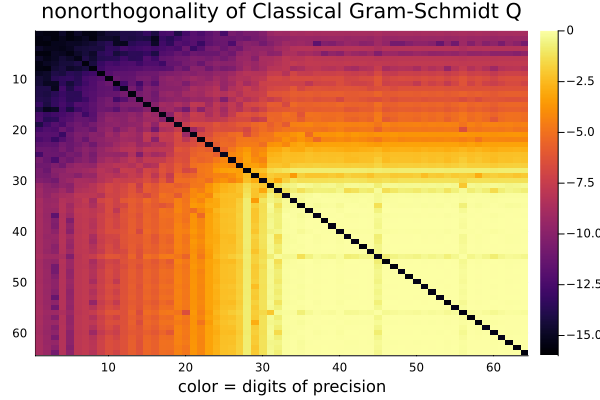

In [53]:
heatmap(log10.(abs.(Qg'*Qg-I) .+ ϵ), yflip=true, clims=(round(log10(ϵ)),0), xlabel="color = digits of precision")
plot!(title="nonorthogonality of Classical Gram-Schmidt Q")

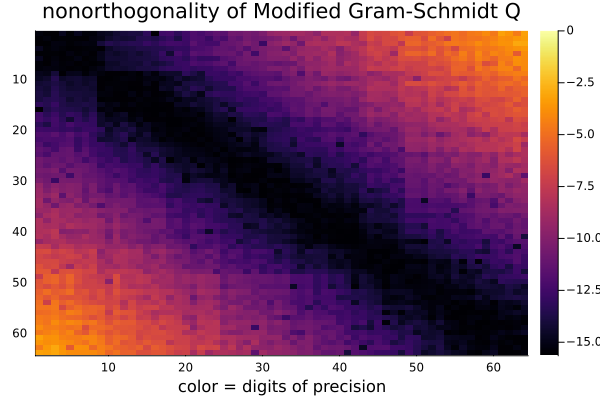

In [55]:
heatmap(log10.(abs.(Qm'*Qm-I) .+ ϵ), yflip=true, clims=(log10(ϵ),0), xlabel="color = digits of precision")
plot!(title="nonorthogonality of Modified Gram-Schmidt Q")

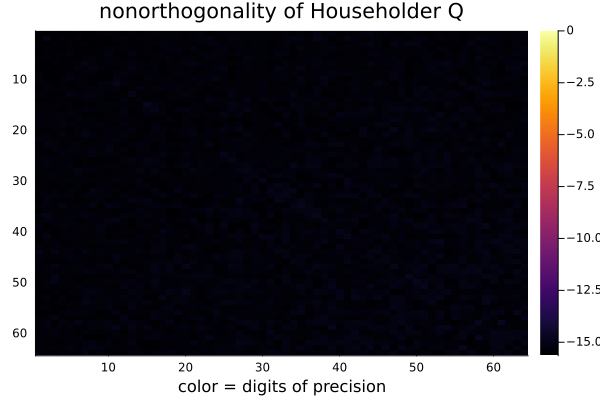

In [56]:
heatmap(log10.(abs.(Qh'*Qh-I) .+ ϵ), yflip=true, clims=(log10(ϵ),0), xlabel="color = digits of precision")
plot!(title="nonorthogonality of Householder Q")

In [ ]:
heatmap(log10.(abs.(Qh'*Qh-I) .+ ϵ), yflip=true,clims=(-15, -17), xlabel="color = digits of precision")

# Floating point arithmetic

In [ ]:
π

In [ ]:
typeof(π)

In [ ]:
big(π)

In [ ]:
typeof(big(π))

In [ ]:
2.6 - 0.9 - 1.7

In [ ]:
x = big(26)/10 - big(9)/10 - big(17)/10

In [ ]:
typeof(x)

In [ ]:
1//7

In [ ]:
typeof(1//7)

In [ ]:
1//3 + 5//7*im

In [ ]:
typeof(1//3+big(5im)//7)

In [ ]:
2.6 - 0.9 - 1.7

In [ ]:
2^-52

In [ ]:
eps(BigFloat)

In [ ]:
eps(Float32)

In [ ]:
big(26)/10 - big(7)/10 - big(19)/10

In [ ]:
typeof(big(19.0))

In [ ]:
eps(BigFloat)

In [ ]:
setprecision(1024)

In [ ]:
BigFloat(pi)

In [ ]:
π

In [ ]:
T = Float64
pie = T(pi)

In [ ]:
exponent(pie)

In [ ]:
significand(pie)

In [ ]:
for T in [Float16; Float32; Float64; BigFloat]
    @show eps(T)
end

In [ ]:
for T in [Float16; Float32; Float64; BigFloat]
    @show nextfloat(T(0))
end

In [ ]:
function f(x)
    4x+3
end

In [ ]:
@code_lowered f(1.0)

In [ ]:
@code_llvm f(1.0)

In [ ]:
@code_native f(1.0)

In [ ]:
using Polynomials

P = Polynomial([2, 3, 1])

In [ ]:
P(3)

In [ ]:
typeof(P)

In [ ]:
R = Polynomial([1//2, 3//4, 5//7])

In [ ]:
typeof(1//3)

In [ ]:
big(1)//3 + 13//57*im

In [ ]:
typeof(ans)

In [ ]:
bitstring(0.5)

In [ ]:
bitstring(5.25)

In [ ]:
typeof(Float64)